### Enhancing data


When running `pre_et_look`, on some variables extra functions are applied. In this notebook we'll take a closer look at those functions and how to modify them.

First we install pywapor, in case it's not installed yet.

In [ ]:
!pip install pywapor==2.5.0 --quiet

And define the usual parameters.

In [1]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks_5"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
timelim = ["2021-07-01", "2021-07-11"]
level = "level_1"
sources = pywapor.general.levels.pre_et_look_levels(level)


There are two moments at which these extra functions are applied. 

Firstly, just after downloading a certain variable "enhancer" functions are applied. These functions can be configured per datasource and product. Let's say you would like to use `t_air` data from different sources, but they come in different units for some reason. In that case you could apply a function to one of them, to convert the data. Another example could be that a certain datasets contains gaps, and you'd want to apply a gap filler to that specific product (think Landsat 7).

Secondly, after having created the composites for all the variables, some functions can be applied to further improve the data. For example the temperature variables are enhanced by using the elevation variable to apply a lapse rate correction.

Let's focus on three variables in this notebook (`ndvi`, `t_air` and `z`). We'll remove the other ones from `sources` like this.

In [2]:
sources = {k: v for k, v in sources.items() if k in ["ndvi", "t_air", "z"]}

Next we run `pre_et_look` for the standard case.

In [3]:
ds = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, 
                                sources = sources)

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
    --> Applying 'mask_qa'.
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
    --> Applying 'mask_qa'.
    --> Collecting `z` from SRTM.30M.
    --> Collecting `t_air` from GEOS5.inst3_2d_asm_Nx.
    --> Applying 'kelvin_to_celsius'.
    --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
    --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
    --> Compositing `ndvi` (mean).
    --> Using `reproject_chunk` on 30M.nc:z (bilinear).
    --> Using `reproject_bulk` on inst3_2d_asm_Nx.nc:t_air (bilinear).
    --> Compositing `t_air` (mean).
    --> Calculating local means (r = 0.25°) of `z`.
    --> Applying 'lapse_rate'.
    --> Applying 'rename_vars'.
    --> Applying 'fill_attrs'.
    --> Applying 'calc_doys'.
    --> Applying 'add_constants'.
< PRE_ET_LOOK (0:01:33.649108)


As you can see, a function called `kelvin_to_celsius` has been applied to `t_air` from `GEOS5.inst3_2d_asm_Nx`. We can also see that by plotting the temperature.

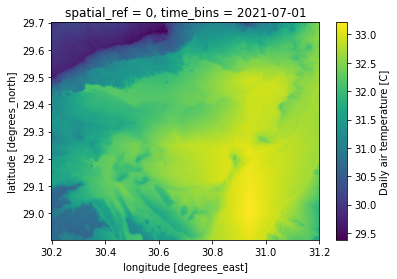

In [4]:
%matplotlib inline
ds.t_air_24.isel(time_bins = 0).plot()

The default enhancers for a specific product can be accessed like this.

In [5]:
pywapor.collect.product.GEOS5.default_post_processors("inst3_2d_asm_Nx", "t_air")

{'t_air': [<function pywapor.enhancers.temperature.kelvin_to_celsius(ds, var, in_var=None, out_var=None)>]}

Changing them happens through the `enhancers` key of the specific variable and product in `sources`, as you can see it's currectly set to `'default'`.

In [6]:
sources["t_air"]["products"][0]

{'source': 'GEOS5', 'product_name': 'inst3_2d_asm_Nx', 'enhancers': 'default'}

Instead of providing the string `'default'`, we can also supply a list of functions instead. So giving an empty list will disable the `kelvin_to_celcius` function.

In [7]:
sources["t_air"]["products"][0]["enhancers"] = []

Before rerunning `pre_et_look`, we'll delete the GEOS5 data, to force the script to recalculate it.

In [8]:
import os
os.remove(os.path.join(project_folder, "GEOS5", "inst3_2d_asm_Nx.nc"))

ds = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, 
                                sources = sources)

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
    --> Collecting `z` from SRTM.30M.
    --> Collecting `t_air` from GEOS5.inst3_2d_asm_Nx.
    --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
    --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
    --> Compositing `ndvi` (mean).
    --> Using `reproject_chunk` on 30M.nc:z (bilinear).
    --> Using `reproject_bulk` on inst3_2d_asm_Nx.nc:t_air (bilinear).
    --> Compositing `t_air` (mean).
    --> Calculating local means (r = 0.25°) of `z`.
    --> Applying 'lapse_rate'.
    --> Applying 'rename_vars'.
    --> Applying 'fill_attrs'.
    --> Applying 'calc_doys'.
    --> Applying 'add_constants'.
< PRE_ET_LOOK (0:00:32.699779)


The temperature is now stored in Kelvin.

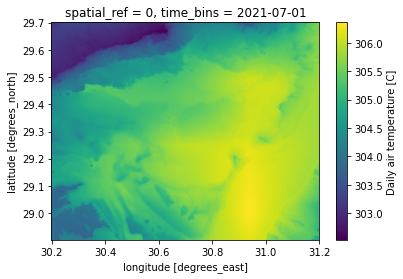

In [9]:
ds.t_air_24.isel(time_bins = 0).plot()

Another type of enhancement is applied near the end of `pre_et_look`. These functions can be adjusted through the keyword argument `enhancers` in the `pywapor.pre_et_look.main` function.

For example, runnning with an empty list, will disable the `lapse_rate` correction.

In [10]:
ds = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, 
                                sources = sources, enhancers = [])

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
    --> Collecting `z` from SRTM.30M.
    --> Collecting `t_air` from GEOS5.inst3_2d_asm_Nx.
    --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
    --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
    --> Compositing `ndvi` (mean).
    --> Using `reproject_chunk` on 30M.nc:z (bilinear).
    --> Using `reproject_bulk` on inst3_2d_asm_Nx.nc:t_air (bilinear).
    --> Compositing `t_air` (mean).
    --> Applying 'rename_vars'.
    --> Applying 'fill_attrs'.
    --> Applying 'calc_doys'.
    --> Applying 'add_constants'.
< PRE_ET_LOOK (0:00:23.029187)


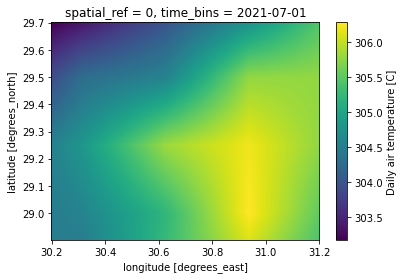

In [11]:
ds.t_air_24.isel(time_bins = 0).plot()